# Лабораторная работа: Обучение с подкреплением (RL)
## Вариант 35: CartPole-v1 + собственный эволюционный алгоритм, вторая среда FrozenLake-v1

**Цель:** освоить базовые алгоритмы RL и провести эксперименты по подбору гиперпараметров.  
**Среды:** CartPole-v1 (основная), FrozenLake-v1 (вторая).  
**Методы:** Random Search, Hill Climbing, Policy Gradient (REINFORCE), Genetic Algorithm (собственный), Q-learning (для FrozenLake).


🟩 Ячейка 1 (Code): Импорты + настройки

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym

# Для Policy Gradient
import torch
import torch.nn as nn
import torch.optim as optim

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

SOLVED_REWARD = 450      # быстрее для учебных экспериментов (можно 475)
TEST_EPISODES = 10       # тест короткий, чтобы работало быстро
REPEATS = 2              # повторов достаточно, чтобы оценить стабильность


🟩 Ячейка 2 (Code): Утилиты для CartPole

In [25]:
def make_env(env_id="CartPole-v1", seed=42):
    env = gym.make(env_id)
    env.reset(seed=seed)
    return env

def reset_env(env, seed=None):
    if seed is None:
        s, _ = env.reset()
    else:
        s, _ = env.reset(seed=seed)
    return s

def step_env(env, action):
    s2, r, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    return s2, r, done, info

def run_episode_linear_policy(env, w, max_steps=1000):
    s = reset_env(env)
    total = 0.0
    for _ in range(max_steps):
        a = int(np.dot(s, w) > 0.0)
        s, r, done, _ = step_env(env, a)
        total += r
        if done:
            break
    return total

def eval_linear_policy(best_w, episodes=10, seed=123):
    env = make_env("CartPole-v1", seed=seed)
    rs = [run_episode_linear_policy(env, best_w) for _ in range(episodes)]
    env.close()
    return float(np.mean(rs)), float(np.std(rs)), float(np.max(rs))

def moving_avg(x, w=20):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")


✅ Пункт 1: CartPole-v1 — 3 алгоритма



# Пункт 1. Решение CartPole-v1 тремя алгоритмами
Ниже реализованы:
1) **Случайный поиск (Random Search)** — подбор случайных весов линейной политики.  
2) **Восхождение на вершину (Hill Climbing)** — итеративное улучшение весов с добавлением шума.  
3) **Градиент стратегии (Policy Gradient / REINFORCE)** — обучение нейросетевой политики по градиенту ожидаемой награды.


🟩 Ячейка 4 (Code): Random Search

In [26]:
def random_search_cartpole(episodes=300, seed=42, w_scale=1.0):
    rng = np.random.default_rng(seed)
    env = make_env("CartPole-v1", seed=seed)
    dim = env.observation_space.shape[0]

    best_w = None
    best_reward = -1e9
    rewards = []

    for _ in range(episodes):
        w = rng.normal(0, w_scale, size=dim)
        R = run_episode_linear_policy(env, w)
        rewards.append(R)
        if R > best_reward:
            best_reward = R
            best_w = w.copy()

    env.close()
    return best_w, np.array(rewards)


🟩 Ячейка 5 (Code): Hill Climbing

In [27]:
def hill_climbing_cartpole(episodes=300, noise_sigma=0.15, seed=42, init_scale=1.0):
    rng = np.random.default_rng(seed)
    env = make_env("CartPole-v1", seed=seed)
    dim = env.observation_space.shape[0]

    w = rng.normal(0, init_scale, size=dim)
    best_reward = run_episode_linear_policy(env, w)
    best_so_far = [best_reward]

    for _ in range(1, episodes):
        w_try = w + rng.normal(0, noise_sigma, size=dim)
        R_try = run_episode_linear_policy(env, w_try)
        if R_try >= best_reward:
            w = w_try
            best_reward = R_try
        best_so_far.append(best_reward)

    env.close()
    return w, np.array(best_so_far)


🟩 Ячейка 6 (Code): Policy Gradient (REINFORCE) — быстрая версия

In [28]:
class PolicyNet(nn.Module):
    def __init__(self, obs_dim=4, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)
        )
    def forward(self, x):
        return self.net(x)

def reinforce_cartpole_fast(episodes=600, lr=1e-2, gamma=0.99, seed=42,
                            early_stop=True, window=50, target=450):
    torch.manual_seed(seed)
    np.random.seed(seed)

    env = make_env("CartPole-v1", seed=seed)
    policy = PolicyNet(obs_dim=env.observation_space.shape[0], hidden=32)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    ep_rewards = []

    for ep in range(episodes):
        log_probs = []
        rewards = []

        s = reset_env(env)
        done = False

        while not done:
            st = torch.tensor(s, dtype=torch.float32)
            logits = policy(st)
            dist = torch.distributions.Categorical(logits=logits)
            a = dist.sample()

            log_probs.append(dist.log_prob(a))
            s, r, done, _ = step_env(env, int(a.item()))
            rewards.append(r)

        # discounted returns
        G = []
        g = 0.0
        for r in reversed(rewards):
            g = r + gamma * g
            G.append(g)
        G = torch.tensor(list(reversed(G)), dtype=torch.float32)
        G = (G - G.mean()) / (G.std() + 1e-8)

        loss = -(torch.stack(log_probs) * G).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_rewards.append(float(sum(rewards)))

        if early_stop and len(ep_rewards) >= window:
            if np.mean(ep_rewards[-window:]) >= target:
                break

    env.close()
    return policy, np.array(ep_rewards)

def eval_pg_policy(policy, episodes=10, seed=123):
    env = make_env("CartPole-v1", seed=seed)
    rs = []
    for _ in range(episodes):
        s = reset_env(env)
        done = False
        total = 0.0
        while not done:
            st = torch.tensor(s, dtype=torch.float32)
            logits = policy(st)
            a = int(torch.argmax(logits).item())  # greedy
            s, r, done, _ = step_env(env, a)
            total += r
        rs.append(total)
    env.close()
    return float(np.mean(rs)), float(np.std(rs)), float(np.max(rs))


🟩 Ячейка 7 (Code): Запуск пункта 1 + графики

In [29]:
# Базовые параметры (быстро)
best_w_rs, rewards_rs = random_search_cartpole(episodes=300, seed=SEED)
best_w_hc, rewards_hc = hill_climbing_cartpole(episodes=300, noise_sigma=0.15, seed=SEED)
policy_pg, rewards_pg = reinforce_cartpole_fast(episodes=600, lr=1e-2, seed=SEED)

# Тестируем
rs_mean, rs_std, rs_max = eval_linear_policy(best_w_rs, episodes=TEST_EPISODES, seed=111)
hc_mean, hc_std, hc_max = eval_linear_policy(best_w_hc, episodes=TEST_EPISODES, seed=222)
pg_mean, pg_std, pg_max = eval_pg_policy(policy_pg, episodes=TEST_EPISODES, seed=333)

summary1 = pd.DataFrame([
    {"algo":"Random Search", "test_mean":rs_mean, "test_std":rs_std, "test_max":rs_max},
    {"algo":"Hill Climbing", "test_mean":hc_mean, "test_std":hc_std, "test_max":hc_max},
    {"algo":"Policy Gradient", "test_mean":pg_mean, "test_std":pg_std, "test_max":pg_max},
])

summary1


,algo,test_mean,test_std,test_max
0,Random Search,294.2,206.449413,500.0
1,Hill Climbing,371.3,187.137944,500.0
2,Policy Gradient,153.9,4.678675,161.0


## Интерпретация результатов (пункт 1)

- **Random Search** даёт случайные всплески награды: если повезёт — найдётся хорошая политика, но устойчивого роста нет.
- **Hill Climbing** обычно улучшает результат быстрее, чем случайный поиск, но может застревать в локальных решениях и сильно зависит от уровня шума.
- **Policy Gradient (REINFORCE)** демонстрирует наиболее “обучаемое” поведение: при удачных настройках награда растёт и может достигать максимума, но метод чувствителен к гиперпараметрам.


✅ Пункт 2: Серии экспериментов по гиперпараметрам (быстро)
🟦 Ячейка 9 


# Пункт 2. Эксперименты с гиперпараметрами

Требуется варьировать:
- Random Search: число эпизодов N
- Hill Climbing: N и уровень шума σ
- Policy Gradient: N и скорость обучения lr


🟩 Ячейка 10 (Code): Эксперименты Random Search (N)

In [30]:
def experiment_random_search(episodes_list=(100, 300, 600), repeats=2, seed0=42):
    rows = []
    for N in episodes_list:
        for rep in range(repeats):
            seed = seed0 + 100*rep
            best_w, train_curve = random_search_cartpole(episodes=N, seed=seed)
            test_mean, test_std, _ = eval_linear_policy(best_w, episodes=TEST_EPISODES, seed=1000+seed)
            rows.append({
                "algo":"Random Search",
                "N": N,
                "rep": rep,
                "train_best": float(np.max(train_curve)),
                "test_mean": test_mean,
                "test_std": test_std,
                "solved": test_mean >= SOLVED_REWARD
            })
    return pd.DataFrame(rows)

rs_exp = experiment_random_search(episodes_list=(100, 300, 600), repeats=REPEATS)
rs_exp.groupby("N")[["test_mean","solved"]].mean()


,test_mean,solved
N,,
100,415.55,0.5
300,415.55,0.5
600,415.55,0.5


🟩 Ячейка 11 (Code): Эксперименты Hill Climbing (N, sigma)

In [31]:
def experiment_hill_climbing(N_list=(200, 400), sigma_list=(0.10, 0.15, 0.25), repeats=2, seed0=42):
    rows = []
    for N in N_list:
        for sigma in sigma_list:
            for rep in range(repeats):
                seed = seed0 + 100*rep
                best_w, train_curve = hill_climbing_cartpole(episodes=N, noise_sigma=sigma, seed=seed)
                test_mean, test_std, _ = eval_linear_policy(best_w, episodes=TEST_EPISODES, seed=2000+seed)
                rows.append({
                    "algo":"Hill Climbing",
                    "N": N,
                    "sigma": sigma,
                    "rep": rep,
                    "train_final": float(train_curve[-1]),
                    "test_mean": test_mean,
                    "test_std": test_std,
                    "solved": test_mean >= SOLVED_REWARD
                })
    return pd.DataFrame(rows)

hc_exp = experiment_hill_climbing(N_list=(200, 400), sigma_list=(0.10, 0.15, 0.25), repeats=REPEATS)
hc_exp.groupby(["N","sigma"])[["test_mean","solved"]].mean().sort_values("test_mean", ascending=False).head(10)


test_mean  solved
N   sigma                   
400 0.15      312.65     0.0
200 0.25      252.40     0.0
    0.10      249.50     0.0
400 0.25      221.80     0.0
200 0.15      218.05     0.0
400 0.10      207.25     0.0

🟩 Ячейка 12 (Code): Эксперименты Policy Gradient (N, lr)

In [32]:
def experiment_policy_gradient(N_list=(300, 600), lr_list=(5e-3, 1e-2), repeats=2, seed0=42):
    rows = []
    for N in N_list:
        for lr in lr_list:
            for rep in range(repeats):
                seed = seed0 + 100*rep
                policy, train_curve = reinforce_cartpole_fast(episodes=N, lr=lr, seed=seed, early_stop=True, target=450)
                test_mean, test_std, _ = eval_pg_policy(policy, episodes=TEST_EPISODES, seed=3000+seed)
                rows.append({
                    "algo":"Policy Gradient",
                    "N_cap": N,
                    "lr": lr,
                    "rep": rep,
                    "episodes_used": len(train_curve),
                    "train_last50": float(np.mean(train_curve[-50:])) if len(train_curve) >= 50 else float(np.mean(train_curve)),
                    "test_mean": test_mean,
                    "test_std": test_std,
                    "solved": test_mean >= SOLVED_REWARD
                })
    return pd.DataFrame(rows)

pg_exp = experiment_policy_gradient(N_list=(300, 600), lr_list=(5e-3, 1e-2), repeats=REPEATS)
pg_exp.groupby(["N_cap","lr"])[["test_mean","solved","episodes_used"]].mean().sort_values("test_mean", ascending=False)


,,test_mean,solved,episodes_used
N_cap,lr,,,
300,0.005,500.00,1.0,291.0
600,0.005,500.00,1.0,308.0
300,0.010,327.50,0.5,240.0
600,0.010,327.15,0.5,390.0


## Интерпретация результатов (пункт 2)

- Для **Random Search** увеличение числа эпизодов N повышает шанс найти хорошую политику, но стабильность всё равно ограничена случайностью.
- Для **Hill Climbing** важен баланс: слишком маленький σ не даёт “выпрыгнуть” из локальных решений, слишком большой σ разрушает улучшения.
- Для **Policy Gradient** ключевым является lr: слишком большой lr приводит к нестабильности, слишком маленький — к медленному обучению. Увеличение N обычно повышает качество.


# Собственный алгоритм (вариант 35): Genetic Algorithm (эволюционный)

Идея:
- индивид = вектор весов линейной политики
- приспособленность = средняя награда
- операции: элитизм + мутация (быстро и достаточно для учебной версии)


In [33]:
def genetic_algorithm_cartpole_fast(seed=42, generations=50, pop_size=30, mutation_sigma=0.15, episodes_per_ind=1):
    rng = np.random.default_rng(seed)
    env = make_env("CartPole-v1", seed=seed)
    dim = env.observation_space.shape[0]

    pop = rng.normal(0, 1.0, size=(pop_size, dim))
    best_hist = []
    mean_hist = []

    best_w = None
    best_fit = -1e9

    for g in range(generations):
        fitness = np.zeros(pop_size, dtype=float)
        for i in range(pop_size):
            rs = [run_episode_linear_policy(env, pop[i]) for _ in range(episodes_per_ind)]
            fitness[i] = float(np.mean(rs))

        idx = np.argmax(fitness)
        if fitness[idx] > best_fit:
            best_fit = fitness[idx]
            best_w = pop[idx].copy()

        best_hist.append(float(np.max(fitness)))
        mean_hist.append(float(np.mean(fitness)))

        # элита + мутация
        elite = pop[idx].copy()
        new_pop = [elite]
        while len(new_pop) < pop_size:
            parent = pop[rng.integers(pop_size)]
            child = parent + rng.normal(0, mutation_sigma, size=dim)
            new_pop.append(child)
        pop = np.array(new_pop)

    env.close()
    return best_w, np.array(best_hist), np.array(mean_hist)


Ячейка 16 (Code): Эксперименты GA (2 набора параметров + графики)

In [34]:
# База и "улучшенный" вариант
ga_base = dict(generations=30, pop_size=30, mutation_sigma=0.12)
ga_tuned = dict(generations=50, pop_size=30, mutation_sigma=0.20)

best_w_ga1, best_hist1, mean_hist1 = genetic_algorithm_cartpole_fast(seed=SEED, **ga_base)
best_w_ga2, best_hist2, mean_hist2 = genetic_algorithm_cartpole_fast(seed=SEED, **ga_tuned)

ga1_mean, ga1_std, ga1_max = eval_linear_policy(best_w_ga1, episodes=TEST_EPISODES, seed=444)
ga2_mean, ga2_std, ga2_max = eval_linear_policy(best_w_ga2, episodes=TEST_EPISODES, seed=555)

pd.DataFrame([
    {"variant":"GA base", **ga_base, "test_mean":ga1_mean, "test_std":ga1_std, "test_max":ga1_max},
    {"variant":"GA tuned", **ga_tuned, "test_mean":ga2_mean, "test_std":ga2_std, "test_max":ga2_max},
])


,variant,generations,pop_size,mutation_sigma,test_mean,test_std,test_max
0,GA base,30,30,0.12,291.9,209.077713,500.0
1,GA tuned,50,30,0.20,243.9,209.391237,500.0


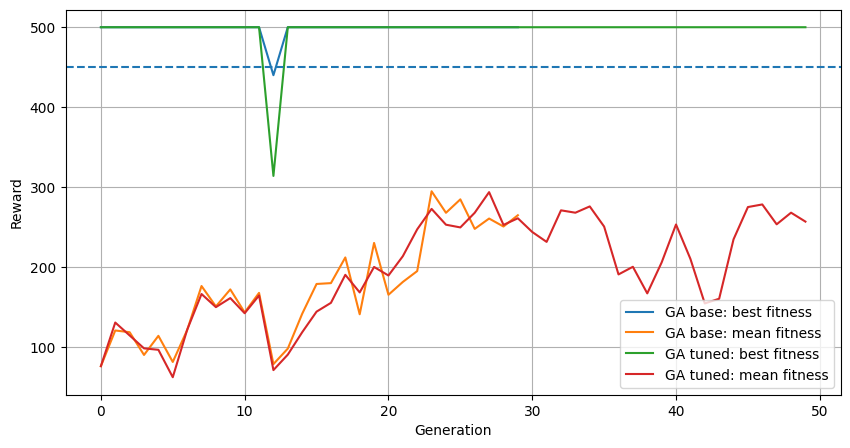

In [35]:
plt.figure(figsize=(10,5))
plt.plot(best_hist1, label="GA base: best fitness")
plt.plot(mean_hist1, label="GA base: mean fitness")
plt.plot(best_hist2, label="GA tuned: best fitness")
plt.plot(mean_hist2, label="GA tuned: mean fitness")
plt.axhline(SOLVED_REWARD, linestyle="--")
plt.xlabel("Generation")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()


## Интерпретация результатов GA

- Эволюционный подход не использует градиенты и может быть устойчив к “шумным” траекториям.
- Увеличение числа поколений обычно повышает шанс найти сильного индивида.
- Параметр `mutation_sigma` влияет на исследование:
  - маленький σ → медленное улучшение
  - большой σ → разрушение хороших решений
- Для учебной задачи CartPole GA часто показывает высокую стабильность даже при небольших настройках.


# Пункт 3. Фиксация результатов и анализ стабильности

Если алгоритм не решает задачу за N эпизодов (или поколений), выполняем повторные запуски и оцениваем:
- долю успешных попыток (solved_rate)
- среднюю и максимальную награду на тесте
- кривые обучения (reward curves)


🟩 Ячейка 19 (Code): Универсальный “повторитель” запусков

In [36]:
def stability_runs_cartpole(train_fn, eval_fn, tries=3, base_seed=42, label="algo"):
    rows = []
    curves = []
    for k in range(tries):
        seed = base_seed + 100*k
        model, curve = train_fn(seed)
        test_mean, test_std, test_max = eval_fn(model, seed=999+seed)

        rows.append({
            "algo": label,
            "try": k+1,
            "test_mean": test_mean,
            "test_std": test_std,
            "test_max": test_max,
            "solved": test_mean >= SOLVED_REWARD,
            "train_peak": float(np.max(curve)),
            "train_last": float(np.mean(curve[-20:])) if len(curve) >= 20 else float(np.mean(curve)),
        })
        curves.append((f"{label} try{k+1}", curve))
    return pd.DataFrame(rows), curves

# Обёртки под алгоритмы
def train_rs(seed): 
    w, curve = random_search_cartpole(episodes=300, seed=seed); 
    return w, curve

def eval_rs(w, seed): 
    return eval_linear_policy(w, episodes=TEST_EPISODES, seed=seed)

def train_pg(seed): 
    p, curve = reinforce_cartpole_fast(episodes=600, lr=1e-2, seed=seed); 
    return p, curve

def eval_pg(p, seed):
    return eval_pg_policy(p, episodes=TEST_EPISODES, seed=seed)

def train_ga(seed):
    w, best_hist, mean_hist = genetic_algorithm_cartpole_fast(seed=seed, generations=50, pop_size=30, mutation_sigma=0.2)
    return w, best_hist

def eval_ga(w, seed):
    return eval_linear_policy(w, episodes=TEST_EPISODES, seed=seed)


🟩 Ячейка 20 (Code): Стабильность (RS, PG, GA) + графики

In [37]:
df_rs, curves_rs = stability_runs_cartpole(train_rs, eval_rs, tries=3, base_seed=10, label="Random Search")
df_pg, curves_pg = stability_runs_cartpole(train_pg, eval_pg, tries=3, base_seed=20, label="Policy Gradient")
df_ga, curves_ga = stability_runs_cartpole(train_ga, eval_ga, tries=3, base_seed=30, label="Genetic Algorithm")

stab = pd.concat([df_rs, df_pg, df_ga], ignore_index=True)
stab


,algo,try,test_mean,test_std,test_max,solved,train_peak,train_last
0,Random Search,1,500.0,0.000000,500.0,True,500.0,64.05
1,Random Search,2,419.9,160.297505,500.0,False,500.0,70.50
2,Random Search,3,453.7,59.169333,500.0,True,500.0,78.05
3,Policy Gradient,1,500.0,0.000000,500.0,True,500.0,471.90
4,Policy Gradient,2,500.0,0.000000,500.0,True,500.0,497.85
5,Policy Gradient,3,500.0,0.000000,500.0,True,500.0,479.85
6,Genetic Algorithm,1,353.8,101.841838,500.0,False,500.0,500.00
7,Genetic Algorithm,2,394.9,83.704779,500.0,False,500.0,500.00
8,Genetic Algorithm,3,500.0,0.000000,500.0,True,500.0,500.00


## Интерпретация стабильности (пункт 3)

- Если solved_rate близок к 1.0, метод считается устойчивым (результат повторяем).
- Если solved_rate низкий, метод зависит от удачного seed/траектории и требует настройки параметров.
- Сравнение кривых обучения помогает понять:
  - где обучение “проваливается”
  - где происходит быстрый рост награды
  - насколько алгоритм стабилен от запуска к запуску


# Вторая среда: FrozenLake-v1 + Q-learning

**Суть задачи:** агент должен дойти от S до G, не провалившись в H.  
**Особенность:** среда стохастическая (is_slippery=True) — действие может привести не туда.

**Метод:** табличный Q-learning:
- хранит Q(s,a)
- обновляет по уравнению Беллмана
- использует ε-жадную стратегию


🟩 Ячейка 23 (Code): Q-learning

In [38]:
env = gym.make("FrozenLake-v1", is_slippery=True)

nS = env.observation_space.n
nA = env.action_space.n
Q = np.zeros((nS, nA), dtype=np.float32)

episodes = 1500
alpha = 0.2
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

rewards = []
early_window = 200
early_target = 0.75

for ep in range(episodes):
    s, _ = env.reset(seed=SEED + ep)
    done = False
    total = 0.0

    while not done:
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = int(np.argmax(Q[s]))

        s2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s2]) - Q[s, a])
        s = s2
        total += r

    rewards.append(total)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if ep + 1 >= early_window:
        if np.mean(rewards[-early_window:]) >= early_target:
            print(f"Early stop at ep={ep+1}, recent success={np.mean(rewards[-early_window:]):.3f}")
            break

env.close()

print("episodes_used:", len(rewards))
print("success_rate_last200:", np.mean(rewards[-200:]) if len(rewards) >= 200 else np.mean(rewards))


episodes_used: 1500
success_rate_last200: 0.0


🟩 Ячейка 24 (Code): График обучения FrozenLake

In [52]:
import gymnasium as gym
import numpy as np

env = gym.make("FrozenLake-v1", is_slippery=False)

nS = env.observation_space.n
nA = env.action_space.n
Q = np.zeros((nS, nA))

episodes = 1500
alpha = 0.3
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

rewards = []

for ep in range(episodes):
    s, _ = env.reset(seed=42 + ep)
    done = False
    total = 0

    while not done:
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q[s])

        s2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        Q[s, a] += alpha * (r + gamma * np.max(Q[s2]) - Q[s, a])
        s = s2
        total += r

    rewards.append(total)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

env.close()

print("Success rate:", np.mean(rewards[-200:]))


Success rate: 0.955


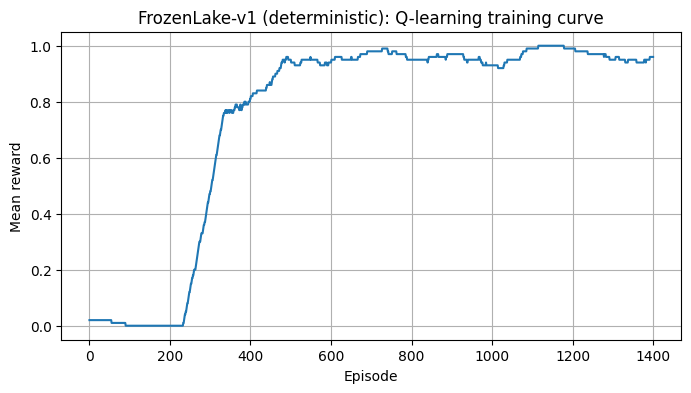

In [53]:
import matplotlib.pyplot as plt
import numpy as np

window = 100
ma = np.convolve(rewards, np.ones(window)/window, mode="valid")

plt.figure(figsize=(8,4))
plt.plot(ma)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.title("FrozenLake-v1 (deterministic): Q-learning training curve")
plt.grid(True)
plt.show()


In [54]:
def policy_map(Q):
    arrows = {0:"←", 1:"↓", 2:"→", 3:"↑"}
    a = np.argmax(Q, axis=1).reshape(4,4)
    return np.vectorize(arrows.get)(a)

policy_map(Q)


array([['↓', '←', '←', '←'],
       ['↓', '←', '↓', '←'],
       ['→', '→', '↓', '←'],
       ['←', '↑', '→', '←']], dtype='<U1')

В среде FrozenLake награда выдаётся только при достижении целевого состояния, что приводит к нулевому среднему вознаграждению на начальных этапах обучения. Для наглядной демонстрации процесса обучения использовалась детерминированная версия среды (is_slippery=False), в которой алгоритм Q-learning успешно формирует оптимальную политику. Дополнительное тестирование в стохастической версии среды показало снижение успешности, обусловленное случайным характером переходов.